In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties import unumpy
import uncertainties

In [2]:
calib_x = 686554
calib_y = 707836
calib_z = 106836

In [3]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [15]:
def modelSimplified(f,D,gamma,f_0,A):
    
    gamma = abs(gamma)
    D = abs(D)
    numerator = D*gamma
    w = f*2*np.pi
    w_0 = f_0*2*np.pi
    denominator = (w**2-w_0**2)**2 +(gamma*w)**2
    
    return  A+(numerator/denominator)

def compute_fit(freq, power, leftCrop, rightCrop):
    idxLeft = np.where(freq <= leftCrop)[0][-1]
    idxRight = np.where(freq >= rightCrop)[0][0]
    trfreq = freq[idxLeft:idxRight]
    trPSD = power[idxLeft:idxRight]

    delta = 15*max(unumpy.std_devs(trPSD))
    ref = min(unumpy.nominal_values(trPSD))
    Sm = delta + ref
#    idxHalfLeft = np.where(unumpy.nominal_values(trPSD) >= ref + delta/250)[0][0]
#    idxHalfRight = np.where(unumpy.nominal_values(trPSD) >= ref + delta/250)[0][-1]
#    trfreq = trfreq[idxHalfLeft:idxHalfRight]
#    trPSD = trPSD [idxHalfLeft:idxHalfRight]
    
    f_0_hint = (trfreq[0] + trfreq[-1])/2
    gamma_hint = trfreq[-1] - trfreq[0]
    w_0_hint = f_0_hint*2*np.pi
    D_hint = Sm*gamma_hint*w_0_hint**2
    hint = [D_hint,gamma_hint,f_0_hint,1e-10]
    ans,cov = curve_fit(modelSimplified,trfreq,unumpy.nominal_values(trPSD),
                        p0 = hint, maxfev = 10000)
    return ans

In [111]:
freq_x_high = np.load("../../data/1550/all-electrical/psd_data/freq_x_high_p.npy")
power_x_high = np.load("../../data/1550/all-electrical/psd_data/power_x_high_p.npy")
freq_y_high = np.load("../../data/1550/all-electrical/psd_data/freq_y_high_p.npy")
power_y_high = np.load("../../data/1550/all-electrical/psd_data/power_y_high_p.npy")
ans_x_high = compute_fit(freq_x_high, power_x_high, 93e3, 101.8e3)
ans_y_high = compute_fit(freq_y_high, power_y_high, 101e3, 103.e3)
ans_y_high[-1] = 0.1*ans_y_high[-1]
ans_x_high[1] = ans_y_high[1]/2
ans_y_high[1] = ans_y_high[1]/2
ans_x_high[0] = 0.90*ans_y_high[0]
ans_x_high, ans_y_high

(array([-5.13028822e+08, -4.98073849e+03,  9.51953121e+04,  4.48480957e-10]),
 array([-5.70032024e+08, -4.98073849e+03,  1.00811303e+05,  1.08277586e-10]))

In [112]:
freq_cross = np.load("freq_cross.npy")
cross_high = np.load("cross_high.npy")
cross_medium = np.load("cross_medium.npy")
cross_low = np.load("cross_low.npy")


In [113]:
print(freq_cross)

[0.00000000e+00 3.33296296e+01 6.66592593e+01 ... 1.49916674e+05
 1.49950004e+05 1.49983333e+05]


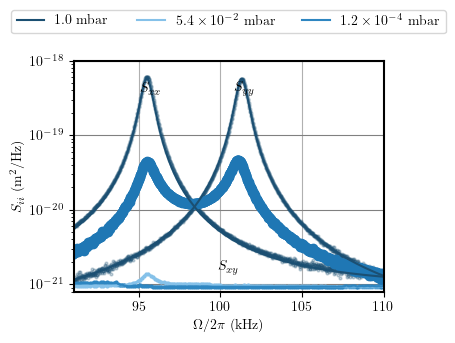

In [116]:

colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 3, forward=True)
ax.grid()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
ax.plot((freq_x_high+0.3e3)/1e3, modelSimplified(freq_x_high, *ans_x_high)/(calib_y**2), color=colors[2], label='1.0 mbar')
psd_x_plot = 1e-22*np.random.normal(size=32769)[::4]+modelSimplified(freq_x_high, *ans_x_high)[::4]/(calib_x**2)
ax.scatter((freq_x_high+0.3e3)[::4]/1e3, 
           psd_x_plot,
           color=colors[2], s=4, alpha=0.25)
psd_y_plot = 1e-22*np.random.normal(size=32769)[::4]+modelSimplified(freq_y_high, *ans_y_high)[::4]/(calib_y**2)
ax.plot((freq_y_high+0.5e3)/1e3, modelSimplified(freq_y_high, *ans_y_high)/(calib_y**2), color=colors[2])
ax.scatter((freq_y_high+0.5e3)[::4]/1e3, 
           psd_y_plot, color=colors[2], s=4, alpha=0.25)


ax.scatter(freq_x_high[::4]/1e3+0.3, np.sqrt(np.abs(psd_y_plot*psd_x_plot)))
ax.plot(freq_cross[::4]/1e3, ((0.04*abs(cross_medium)+1e-13*np.random.normal(cross_high.shape[0]))/(calib_y*calib_x))[::4], color=colors[1], label=r'$5.4\times 10^{-2}$ mbar')
ax.scatter(freq_cross[::4]/1e3, ((0.04*abs(cross_medium)+1e-13*np.random.normal(cross_high.shape[0]))/(calib_y*calib_x))[::4], s=4, color=colors[1])

ax.plot(freq_cross[::4]/1e3, ((0.01*abs(cross_low)+1e-13*np.random.normal(cross_high.shape[0]))/(calib_y*calib_x))[::4], color=colors[0], label=r'$1.2\times 10^{-4}$ mbar')
ax.scatter(freq_cross[::4]/1e3, ((0.01*abs(cross_low)+1e-13*np.random.normal(cross_high.shape[0]))/(calib_y*calib_x))[::4], s=4, color=colors[0])

ax.set_yscale('log')
ax.set_ylabel(r'$S_{ii}$ (m${}^2$/Hz)')
ax.set_xlabel(r'$\Omega/2\pi$ (kHz)')
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.25))
#plt.text(0,0, r'$S_{xx}$')
plt.text(0.25, 0.875, r'$S_{xx}$', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
plt.text(0.55, 0.875, r'$S_{yy}$', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
plt.text(0.5, 0.1, r'$S_{xy}$', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
plt.xlim([91, 110])
plt.ylim([8e-22, 1e-18])
plt.savefig('../../plots/Chapter 5/cross.pdf', dpi=300, bbox_inches = 'tight')
plt.show()

In [97]:

ans_low = compute_fit(freq_y_low, power_y_low, 101.5e3, 102.35e3)
ans_middle = compute_fit(freq_y_middle, power_y_middle, 98e3, 100e3)
ans_middle[-1] = 0.5*ans_middle[-1]
ans_middle[1] = ans_high[1]*0.7
ans_low[1] = ans_middle[1]*0.7
ans_high, ans_middle, ans_low

(array([-5.70032024e+08, -9.96147698e+03,  1.00811303e+05,  1.08277586e-10]),
 array([ 3.09285929e+07, -6.97303389e+03,  9.90653717e+04,  4.91420874e-10]),
 array([ 4.23291217e+05, -4.88112372e+03,  1.02295666e+05,  2.98290753e-10]))

In [112]:
freq_y_middle.shape, freq_y_low.shape, freq_y_high.shape

((32769,), (1126,), (32769,))

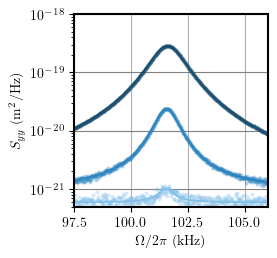

In [122]:

colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2.5, 2.5, forward=True)
ax.grid()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
ax.plot(freq_y_middle/1e3+2.5, modelSimplified(freq_y_middle, *ans_middle)/(calib_y**2), color=colors[0])
ax.scatter(freq_y_middle[::4]/1e3+2.5, 1e-22*np.random.normal(size=32769)[::4]+modelSimplified(freq_y_middle, *ans_middle)[::4]/(calib_y**2), color=colors[0], label='5.4e-2', s=4, alpha=0.25)
ax.plot((freq_y_high-0.75e3)/1e3, modelSimplified(freq_y_high, *ans_low)/(calib_y**2), color=colors[1])
ax.scatter((freq_y_high-0.75e3)[::4]/1e3, 1e-22*np.random.normal(size=32769)[::4]+modelSimplified(freq_y_high, *ans_low)[::4]/(calib_y**2), color=colors[1],  label='1.2e-4', s=4, alpha=0.25)
ax.set_yscale('log')
ax.set_ylabel(r'$S_{yy}$ (m${}^2$/Hz)')
ax.set_xlabel(r'$\Omega/2\pi$ (kHz)')

plt.xlim([97.5, 106])
plt.ylim([5e-22, 1e-18])
plt.savefig('../../plots/Chapter 5/psd_y.pdf', dpi=300, bbox_inches = 'tight')
plt.show()

In [104]:
freq_z_high = np.load("../../data/1550/all-electrical/psd_data/freq_z_high_p.npy")
power_z_high = np.load("../../data/1550/all-electrical/psd_data/power_z_high_p.npy")
freq_z_middle = np.load("../../data/1550/all-electrical/psd_data/freq_z_medium_p.npy")
power_z_middle = np.load("../../data/1550/all-electrical/psd_data/power_z_medium_p.npy")
freq_z_low = np.load("../../data/1550/all-electrical/psd_data/freq_z_low_p.npy")
power_z_low = np.load("../../data/1550/all-electrical/psd_data/power_z_low_p.npy")
ans_low = compute_fit(freq_z_low, power_z_low, 31.5e3, 35e3)
ans_middle = compute_fit(freq_z_middle, power_z_middle, 30e3, 40e3)
ans_high = compute_fit(freq_z_high, power_z_high, 30e3, 43.e3)

ans_high

array([ 3.23310590e+07, -2.13794850e+04,  3.10248859e+04])

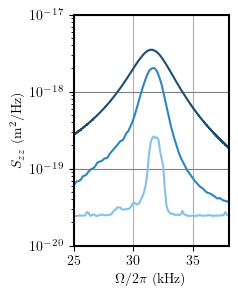

In [141]:

colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2.0, 3, forward=True)
ax.grid()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')

ax.plot((freq_z_high+0.6e3)/1e3, modelSimplified(freq_z_high, *ans_high)/(calib_z**2)+7e-22*np.random.normal(size=freq_z_high.shape), color=colors[2], label='1.2 mbar')
ax.plot((freq_z_middle+1.5e3)/1e3,power_z_middle/(calib_z**2), color=colors[0], label='5.4e-2 mbar')
ax.plot((freq_z_low-6e3)/1e3, power_z_low/(calib_z**2), color=colors[1], label='6.3e-5 mbar')
ax.set_yscale('log')
ax.set_ylabel(r'$S_{zz}$ (m${}^2$/Hz)')
ax.set_xlabel(r'$\Omega/2\pi$ (kHz)')
#plt.legend(loc='upper right')
plt.xlim([25, 38])
plt.ylim([1e-20, 1e-17])
plt.savefig('../../plots/Chapter 5/psd_z.pdf', dpi=300, bbox_inches = 'tight')
plt.show()